Poetry generation

Попробуем сгенерировать стихи, используя RNNs. 

Есть несколько вариантов: 

* Сонеты Шекспира, файл `sonnets.txt` доступный в каталоге записной книжки.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).


Генерация текста может быть реализована в несколько этапов:
    
1. Data loading. -- загрузка данных 
2. Dictionary generation. -- генерация словарей
3. Data preprocessing. -- предварительная обработка данных
4. Model (neural network) training. -- обучение модели (нейронной сети)
5. Text generation (model evaluation). -- генерация текста (оценка модели)

In [ ]:
import string
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Сонеты Шекспира доступны по этой ссылке [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, они хранятся в том же каталоге, что и эта записная книжка (sonnetes.txt).

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616
maxlen_ = len(max(text, key = len))
print("Max seq contains {} symbols".format(maxlen_))

--2021-07-17 21:20:29--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.003s  

2021-07-17 21:20:29 (36.9 MB/s) - ‘sonnets.txt’ saved [119748/119748]

Max seq contains 63 symbols


Введем все символы в нижний регистр. Теперь переменный текст - это список строк. Соединим все строки в одну.

In [ ]:
text = "".join([x.lower() for x in text])

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    o_text = iofile.readlines()
    
o_text = [x.replace('\t\t', '') for x in o_text]
maxlen = len(max(o_text, key = len))
print("Max seq contains {} symbols".format(maxlen))

--2021-07-17 21:20:36--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.005s  

2021-07-17 21:20:36 (45.6 MB/s) - ‘onegin.txt’ saved [262521/262521]

Max seq contains 159 symbols


Введем все символы в нижний регистр. Теперь переменный текст - это список строк. Соединим все строки в одну.

Поместим все символы, которые видели в тексте, в токены переменных.[Текст ссылки](https://)



In [ ]:
def prepare_data(text):
    text = "".join([x.lower() for x in text])
    print("The lenght of given tokens  = {}".format(len(text)))

    tokens = sorted(set(text))
    print("Number of given tokens  = {}".format(len(tokens)))

    return tokens, text
tokens, text = prepare_data(text)

The lenght of given tokens  = 100225
Number of given tokens  = 38


Создаем словарь  `token_to_idx = {<char>: <index>}` и словарь `idx_to_token = {<index>: <char>}`

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

*Комментарий: в этой задаче всего 38 разных токенов, поэтому воспользуемся one-hot encoding.*

In [ ]:
batch_size = 512

# def one_hot_encode(sequence, dict_size = len(tokens_sh)):
#     seq_len = len(sequence)
#     features = np.zeros((seq_len, dict_size), dtype = np.int64)
#     features[np.arange(seq_len), [token_to_idx[s] for s in sequence]] = 1

#     return features

def create_mapping(tokens):
    """
    INPUT: tokens -- sorted set of tokens
    OUTPUT: 
    token_to_idx: dict <index>:<char>
    idx_to_token:dict <char>:<index>
    """
    token_to_idx = {token: idx for idx, token in enumerate(tokens)}
    idx_to_token = dict(enumerate(tokens))
    return token_to_idx, idx_to_token


token_to_idx, idx_to_token = create_mapping(tokens)

def prepare_set(text, tokens, maxlen, step = 1):
    token_to_idx, idx_to_token = create_mapping(tokens)
    sentences, next_tokens = [], []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i : i + maxlen])
        next_tokens.append(text[i + maxlen])

    print("Number of sequences:", len(sentences))
    x = np.zeros((len(sentences), maxlen, len(tokens)))
    y = np.zeros((len(sentences), len(tokens)))
    for i, sentence in enumerate(sentences):
        for t, token in enumerate(sentence):
            x[i, t, token_to_idx[token]] = 1
        y[i, token_to_idx[next_tokens[i]]] = 1  
    return x, y

In [ ]:
text

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.\n\n  ii\n\n  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were

In [ ]:
x, y = prepare_set(text, tokens, maxlen = 64)
print(x.shape)

Number of sequences: 100161
(100161, 64, 38)


### Building the model

Теперь мы хотим построить и обучить рекуррентную нейронную сеть, которая будет похожа на стихи Шекспира.

Воспользуемся vanilla RNN.

In [ ]:
# Your code here  
class VanillaRNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128,
                 n_layers = 1):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

Построим функцию потерь (ось X: количество эпох, ось Y: функция потерь).

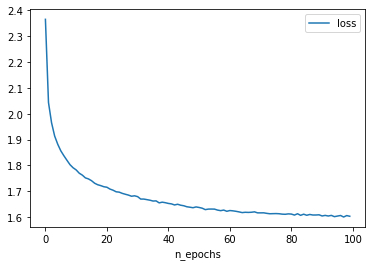

In [ ]:
# Your plot code here
model_rnn = VanillaRNN()
opt = torch.optim.Adam(model_rnn.parameters())
model_rnn.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 100
history = []
_ = model_rnn.train()

for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_rnn.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        opt.zero_grad()
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)


        seq, hidden_state = model_rnn(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
        hidden_state = hidden_state.detach()

    history.append(np.mean(ep_history))
    print("Loss after the epoch # {}".format(epoch + 1), history[-1])
    if (epoch + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history, label = 'loss')
        plt.xlabel("n_epochs")
        plt.legend()
        plt.show()

In [ ]:
# _ = save_net(model_rnn, "O_RNN.net", opt)

In [ ]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'smile ', 
                    max_length = 100, temperature = 1., flag = False):
  
    def sample(preds, tokens, temperature = 1.):
        preds =  F.softmax(preds / temperature, dim = -1).cpu().data.numpy().squeeze()
        # print(preds.shape)
        next_ix = np.random.choice(len(tokens), p = preds)
        return torch.LongTensor([[next_ix]])

    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, i].long()]), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        next_ix = sample(out, tokens, temperature)

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)
    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
# An example of generated text.
# checkpoint = torch.load("ShRNN.net")
# model_rnn.load_state_dict(checkpoint['state_dict'])
# opt.load_state_dict(checkpoint['opt_state_dict'])
_ = model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

smile  sore, not ud;
  when i love wound.
  pfur ison'd wistes
  uble the weersh of what the sell'd thou way my shall gnat eyes i in both whereand elems there sate,
    a tell than to his fiicqooy day in joys my herse pal.

  lxxxi

  but hath i frem'd to shinks um theirs and state.
' thiins, wasidmul'n thee a trus, ton pither,
  thou igh thee of thee thy dear distills thou lass contred faupt,
  thy soul sindldatis yestul posessed in the barmence;
  but that where art thou cheet doth the mind si


### More poetic model

Давайте использовать LSTM вместо vanilla RNN и сравним результаты.

Построим функцию потерь количества эпох. Становится ли финальная потеря лучше?

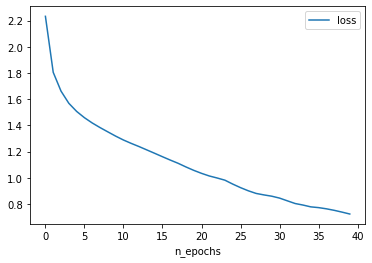

In [ ]:
# Your beautiful code here
class LSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
      
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

model_lstm = LSTM()
opt = torch.optim.Adam(model_lstm.parameters())
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 40
history = []
_ = model_lstm.train()
for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_lstm.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

        hidden_state = tuple([each.data for each in hidden_state])

        opt.zero_grad()
    
        seq, hidden_state = model_lstm(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
    history.append(np.mean(ep_history))
    print("Loss after the epoch # {}".format(epoch + 1), history[-1])

    if (epoch + 1) % 5 == 0:
        clear_output(True)
        plt.plot(history, label = 'loss')
        plt.xlabel("n_epochs")
        plt.legend()
        plt.show()

Сгенерируем текст с помощью обученной сети с другим параметром температуры: [0.1, 0.2, 0.5, 1.0, 2.0]. 
Оценим результаты визуально, попробуем их интерпретировать.

In [ ]:
# _= save_net(model_lstm, "O_LSTM.net", opt)

In [ ]:
# Text generation with different temperature values here 
# checkpoint = torch.load("ShLSTM.net")
# model_lstm.load_state_dict(checkpoint['state_dict'])
# opt.load_state_dict(checkpoint['opt_state_dict'])

_ = model_lstm.eval()

# def entropy(labels, base = None):
#   values, counts = np.unique(labels, return_counts = True)
#   norm_counts = counts / counts.sum()
#   base = np.exp(1.) if base is None else base
#   return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print("TEMPERATURE = ", temperature)
  poetry = generate_text(char_rnn = model_lstm, temperature = temperature,
                      max_length = 400, seed_phrase = "A few years ago ")
  # print("Shannon entropy of given phrase = ", round(entropy(poetry), 3), '\n')

  print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 a few years ago show;
  and therein sains to be self-loves so,
    that she thou most for my heart doth love
  what thou to his fenders on the sure thee,
    and see the barenes and such a counterf's new:
  painting time's scythe thou know'st i thought,
  that is my heart thy self thy self to be.
    i that beauty shall i think in thy heart;
  and in my sight is my heart to me,
    and see the bar 

TEMPERATURE =  0.2
	 a few years ago my use
  desire, be thou most both to lies on thee,
  and my thoughts, some in thy pitch,
  who leaves unswers never course of thine,
  that he says thou be dispeecion can see,
    that i have swalls of this straight in my side thee,
    and their proud heart thy self thy self alone,
  the see to his bend in thy heart,
  and still she say thou lov'st in the sure,
    i have sworn t 

TEMPERATURE =  0.5
	 a few years ago die.
  but well are brought thee fair from my soul did prove:
  so thou uservess go despise thee most,
  the say th

### Saving and loading models

Сохраним модель на диск, затем загрузим ее и сгенерируем текст.

In [ ]:
# Saving and loading code here
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

_= save_net(model_lstm, "Sh_LSTM.net", opt)
checkpoint = torch.load("Sh_LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
opt.load_state_dict(checkpoint['opt_state_dict'])
_ = model_lstm.eval()
print(generate_text(char_rnn = model_lstm, temperature = 1.,
                      max_length = 450, seed_phrase = "Listen, You! "))

listen, you! thy sing,
  trancling still commm'd on the sunfe's 'will'd,
  may doungurs me that newer cruel;
  that farious on the short object:
  so flome shall time do i am to his,
  thy service--warriess onwards, so seen,
  and when it we our find others hours awar,
  shall conver's be mison of love is woll.
  for your mind, or night unmer'd,  thine eye, to bitten'd,
  and by the swall, to my faults sale rain
  though i was new love's feeling:


Загрузка моделей для генерации текста закомментирована в начале каждого `generate_text`. Видно, что с ростом температуры случайность сгенерированного текста сильно увеличивается.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)